<a href="https://colab.research.google.com/github/C-JoGit/Medic_Vision/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Number of images in the train set :  130
Number of images in the test set ;  17
Number of images in prediction set :  16


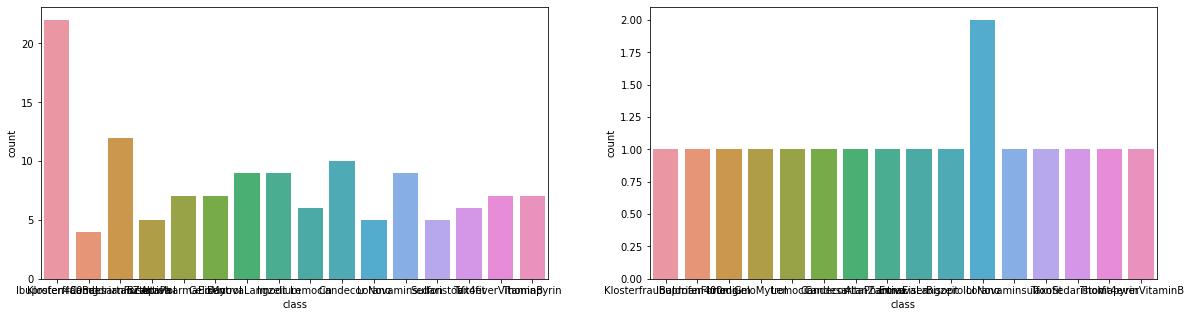

In [3]:
root_path = '/content/drive/MyDrive/pictures'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '/content/drive/MyDrive/pictures/train/'
seg_test_folders = '/content/drive/MyDrive/pictures/val/'
seg_pred_folders = '/content/drive/MyDrive/pictures/pred/'
quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))

for folder in os.listdir(seg_test_folders):
    quantity_te[folder] = len(os.listdir(seg_test_folders+folder))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))
number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in prediction set : ",number_of_images_in_prediction_set)

plt.show()

In [4]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_test_folders, shuffle=True, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 130 images belonging to 16 classes.
Found 16 images belonging to 16 classes.


In [6]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'AltaPharmaEisen': 0, 'Bisoprolol': 1, 'Candecor': 2, 'CandesartanZantiva': 3, 'EunovaLangzeit': 4, 'GeloMytrol': 5, 'Ibuprofen400mg': 6, 'Imodium': 7, 'KlosterfrauBaldrianForte': 8, 'Lemocin': 9, 'Lorano': 10, 'Novaminsulfon': 11, 'Sedariston': 12, 'Taxofit': 13, 'Thomapyrin': 14, 'Vit4everVitaminB': 15}
{0: 'AltaPharmaEisen', 1: 'Bisoprolol', 2: 'Candecor', 3: 'CandesartanZantiva', 4: 'EunovaLangzeit', 5: 'GeloMytrol', 6: 'Ibuprofen400mg', 7: 'Imodium', 8: 'KlosterfrauBaldrianForte', 9: 'Lemocin', 10: 'Lorano', 11: 'Novaminsulfon', 12: 'Sedariston', 13: 'Taxofit', 14: 'Thomapyrin', 15: 'Vit4everVitaminB'}


In [7]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        image_ids = os.listdir(os.path.join(seg_train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

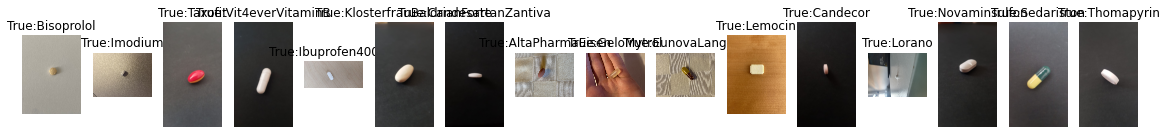

In [ ]:
show_few_images(1)

In [14]:
import tensorflow as tf
tf.keras.backend.clear_session()

# epoch config
benchmark_epoch = 60
vgg_epoch = 60
resnet_epoch = 60
inception_epoch = 60

In [16]:
from tensorflow.keras import layers, Model
#random architecture
benchmark_model = tensorflow.keras.Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(layers.Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(layers.Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(layers.Flatten())
benchmark_model.add(layers.Dense(128,activation='relu'))
benchmark_model.add(layers.Dense(16,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 144, 128)     18944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 67, 64)        204864    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2

In [ ]:
#filepath = "bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
#checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#history = benchmark_model.fit(train_generator,epochs=benchmark_epoch, verbose=1, validation_data = validation_generator,callbacks=[reduce_lr,early_stopping,checkpoint], steps_per_epoch=4, validation_steps=1)

#benchmark_model.save(filepath)
#do_history_stuff(history, 'benchmark_model')

Epoch 1/20
13/13 [==============================] - 123s 8s/step - loss: 4.9590 - acc: 0.0885 - val_loss: 3.8446 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to bench_mark_-model-01-0.00.hdf5
Epoch 2/20
13/13 [==============================] - 98s 8s/step - loss: 2.5745 - acc: 0.1955 - val_loss: 2.9417 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/20
13/13 [==============================] - 103s 8s/step - loss: 2.4847 - acc: 0.2043 - val_loss: 3.6572 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/20
13/13 [==============================] - 101s 8s/step - loss: 2.0886 - acc: 0.2936 - val_loss: 3.7661 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.00000
Epoch 5/20
13/13 [==============================] - 95s 7s/step - loss: 1.9836 - acc: 0.3541 - val_loss: 5.8606 - val_acc: 0.0000e+00

Epoch 00005: val_acc did not improve from 0.00000
Epoch 6/20
13/13 [=====

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


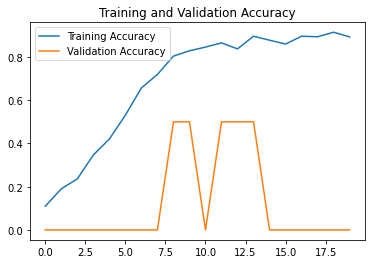

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


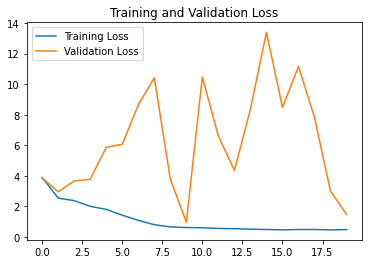

<Figure size 432x288 with 0 Axes>

In [ ]:
filepath = "bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_model.fit(train_generator, batch_size=10, epochs=benchmark_epoch, verbose=1, validation_data = validation_generator,callbacks=[reduce_lr,early_stopping,checkpoint], steps_per_epoch=13, validation_steps=2)

benchmark_model.save(filepath)
do_history_stuff(history, 'benchmark_model')

Epoch 1/60
5/5 [==============================] - 47s 9s/step - loss: 2.8109 - acc: 0.0923 - val_loss: 2.8841 - val_acc: 0.0625

Epoch 00001: val_acc improved from -inf to 0.06250, saving model to vgg_16_-saved-model-01-acc-0.06.hdf5
Epoch 2/60
5/5 [==============================] - 38s 9s/step - loss: 2.6081 - acc: 0.1692 - val_loss: 2.9565 - val_acc: 0.0625

Epoch 00002: val_acc did not improve from 0.06250
Epoch 3/60
5/5 [==============================] - 39s 7s/step - loss: 2.5370 - acc: 0.1769 - val_loss: 2.9553 - val_acc: 0.0625

Epoch 00003: val_acc did not improve from 0.06250
Epoch 4/60
5/5 [==============================] - 39s 9s/step - loss: 2.5223 - acc: 0.1692 - val_loss: 2.9279 - val_acc: 0.0625

Epoch 00004: val_acc did not improve from 0.06250
Epoch 5/60
5/5 [==============================] - 38s 7s/step - loss: 2.4267 - acc: 0.1846 - val_loss: 2.7345 - val_acc: 0.0625

Epoch 00005: val_acc did not improve from 0.06250
Epoch 6/60
5/5 [==============================] - 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


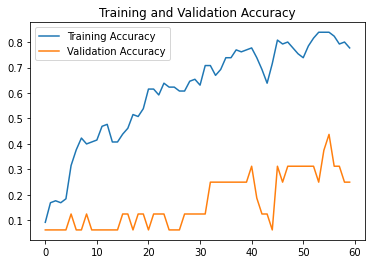

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


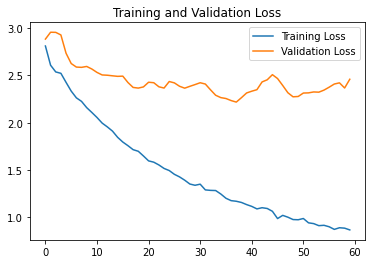

<Figure size 432x288 with 0 Axes>

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = tf.keras.layers.Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(16, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
number_of_epochs = vgg_epoch
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs = 60 ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)

do_history_stuff(vgg16_history, 'vgg16_model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/60
5/5 [==============================] - 62s 10s/step - loss: 5.4178 - acc: 0.2692 - val_loss: 8.7532 - val_acc: 0.0625

Epoch 00001: val_acc improved from -inf to 0.06250, saving model to resnet50-saved-model-01-val_acc-0.06.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/60
5/5 [==============================] - 55s 10s/step - loss: 15.0236 - acc: 0.2308 - val_loss: 44.5278 - val_acc: 0.0625

Epoch 00002: val_acc did not improve from 0.06250
Epoch 3/60
5/5 [==============================] - 55s 13s/step - loss: 4.8773 - acc: 0.2000 - val_loss: 17750.1133 - val_acc: 0.0625

Epoch 00003: val_acc did not improve from 0.06250
Epoch 4/60
5/5 [==============================] - 53s 13s/step - loss: 2.4495 - acc: 0.2846 - val_loss: 12991.9707 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.06250
Epoch 5/60
5/5 [==============================] - 54s 10s/step - loss: 2.2691 - acc: 0.4308 - val_loss: 30971.8789 - val_acc: 0.0000e+00

Epoch 00005: val_acc did not improve from 0.06250
Epoch 6/60
5/5 [==============================] - 53s 9s/step - loss: 2.0499 - acc: 0.4077 - val_loss: 8411.6191 - val_acc: 0.0625

Epoch 00006: val_acc did not improve from 0.06250
Epoch 7/60
5/5 [==============================] - 53s 10s/step - loss: 1.809

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


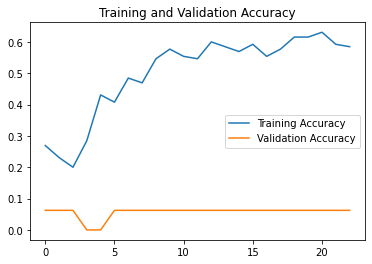

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


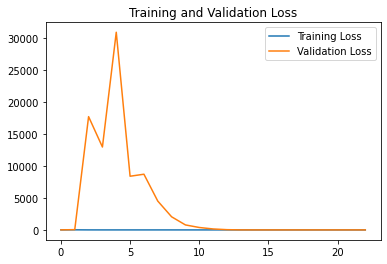

<Figure size 432x288 with 0 Axes>

In [24]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=6)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(16,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)

do_history_stuff(resnet50_history, 'resnet50_model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/60
5/5 [==============================] - 78s 5s/step - loss: 3.4171 - accuracy: 0.0692 - val_loss: 3.7632 - val_accuracy: 0.0625

Epoch 00001: val_accuracy improved from -inf to 0.06250, saving model to inceptionv3_-saved-model-01-loss-3.42.hdf5
Epoch 2/60
5/5 [==============================] - 20s 5s/step - loss: 3.2610 - accuracy: 0.0769 - val_loss: 3.3917 - val_accuracy: 0.0625

Epoch 00002: val_accuracy did not improve from 0.06250
Epoch 3/60
5/5 [==============================] - 20s 4s/step - loss: 2.6919 - accuracy: 0.1846 - val_loss: 3.2960 - val_accuracy: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.06250
Epoch 4/60
5/5 [==============================] - 20s 3s/step - loss: 2.5558 - accuracy: 0.2462 - val_loss: 3.2943 - val_accuracy: 0.0625

Epoch 00004: val_accuracy did not improve from 0.06250
Epoch 5/60
5/5 [==============================] - 20s 3s/step - loss: 2.1530 - accuracy: 0.3231 - val_loss: 3.3203 - val_accuracy: 0.0625

Epoch 00005: val_acc

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


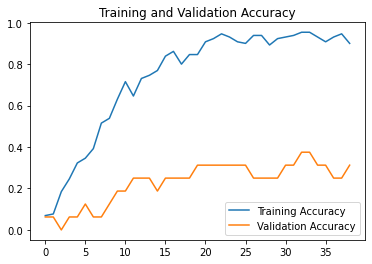

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


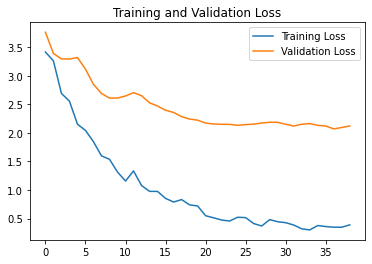

<Figure size 432x288 with 0 Axes>

In [29]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(16, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)

In [30]:
vgg_best_model = vgg16_final_model 
resnet_best_model = resnet50_x_final_model
inception_best_model = InceptionV3_x_final_model 

In [34]:
import cv2
from collections import Counter

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
for folder in os.listdir(seg_test_folders):
    
    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(seg_test_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255
        #vgg
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)
        
        #resnet50
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)
        
        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)
        
        #benchmark
        benchmark_model_prediction = np.argmax(benchmark_model.predict(np.array([img_normalized])))
        benchmark_model_pred.append(benchmark_model_prediction)
        
        #giving vgg16 high priority if they all predict something different
        image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])                                  
        combined_model_pred.append(image_prediction)

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.058823529411764705
                          precision    recall  f1-score   support

         AltaPharmaEisen       0.00      0.00      0.00         1
              Bisoprolol       0.00      0.00      0.00         1
                Candecor       0.00      0.00      0.00         1
      CandesartanZantiva       0.00      0.00      0.00         1
          EunovaLangzeit       0.00      0.00      0.00         1
              GeloMytrol       0.00      0.00      0.00         1
          Ibuprofen400mg       0.00      0.00      0.00         1
                 Imodium       0.00      0.00      0.00         1
KlosterfrauBaldrianForte       0.00      0.00      0.00         1
                 Lemocin       0.00      0.00      0.00         1
                  Lorano       0.00      0.00      0.00         2
           Novaminsulfon       0.07      1.00      0.13         1
              Sedariston       0.00      0.00      0.00         1
                 Taxofit       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


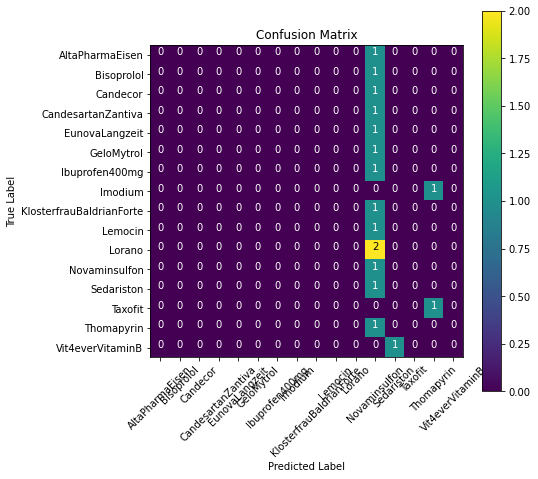

In [39]:
#benchmark model
clf_report(true_value, benchmark_model_pred)

Model Accuracy 0.29411764705882354


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

         AltaPharmaEisen       0.33      1.00      0.50         1
              Bisoprolol       0.00      0.00      0.00         1
                Candecor       0.00      0.00      0.00         1
      CandesartanZantiva       0.00      0.00      0.00         1
          EunovaLangzeit       1.00      1.00      1.00         1
              GeloMytrol       0.00      0.00      0.00         1
          Ibuprofen400mg       0.00      0.00      0.00         1
                 Imodium       0.00      0.00      0.00         1
KlosterfrauBaldrianForte       0.33      1.00      0.50         1
                 Lemocin       0.00      0.00      0.00         1
                  Lorano       0.00      0.00      0.00         2
           Novaminsulfon       0.00      0.00      0.00         1
              Sedariston       1.00      1.00      1.00         1
                 Taxofit       1.00      1.00      1.00         1
         

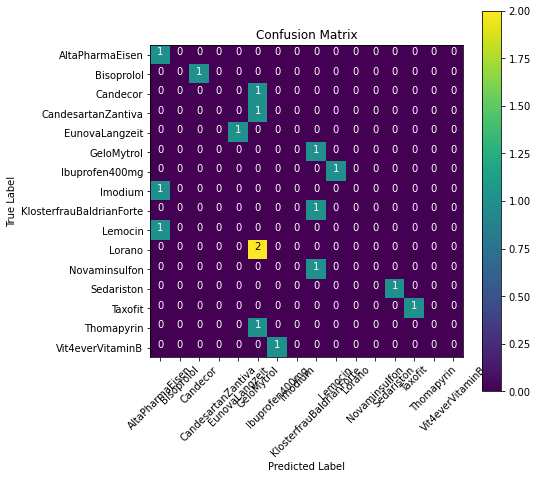

In [40]:
#combined vote
combined_model_pred = [ c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)

Model Accuracy 0.29411764705882354
                          precision    recall  f1-score   support

         AltaPharmaEisen       0.33      1.00      0.50         1
              Bisoprolol       0.00      0.00      0.00         1
                Candecor       0.00      0.00      0.00         1
      CandesartanZantiva       0.00      0.00      0.00         1
          EunovaLangzeit       1.00      1.00      1.00         1
              GeloMytrol       0.00      0.00      0.00         1
          Ibuprofen400mg       0.00      0.00      0.00         1
                 Imodium       0.00      0.00      0.00         1
KlosterfrauBaldrianForte       0.33      1.00      0.50         1
                 Lemocin       0.00      0.00      0.00         1
                  Lorano       0.00      0.00      0.00         2
           Novaminsulfon       0.00      0.00      0.00         1
              Sedariston       1.00      1.00      1.00         1
                 Taxofit       1.00     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


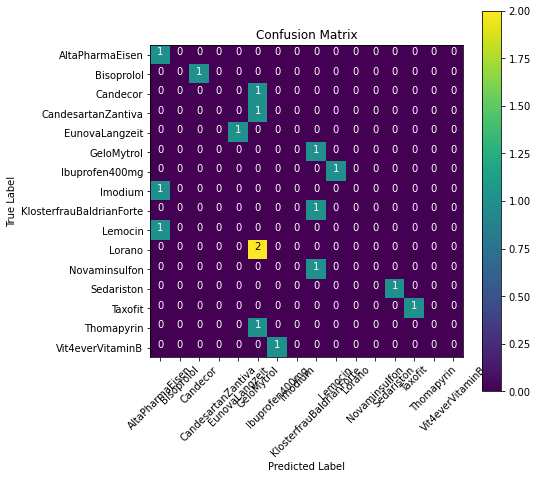

In [41]:
# VGG model classification report
clf_report(true_value, vgg_pred)

Model Accuracy 0.058823529411764705
                          precision    recall  f1-score   support

         AltaPharmaEisen       0.00      0.00      0.00         1
              Bisoprolol       0.00      0.00      0.00         1
                Candecor       0.00      0.00      0.00         1
      CandesartanZantiva       0.00      0.00      0.00         1
          EunovaLangzeit       0.00      0.00      0.00         1
              GeloMytrol       0.00      0.00      0.00         1
          Ibuprofen400mg       0.00      0.00      0.00         1
                 Imodium       0.06      1.00      0.11         1
KlosterfrauBaldrianForte       0.00      0.00      0.00         1
                 Lemocin       0.00      0.00      0.00         1
                  Lorano       0.00      0.00      0.00         2
           Novaminsulfon       0.00      0.00      0.00         1
              Sedariston       0.00      0.00      0.00         1
                 Taxofit       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


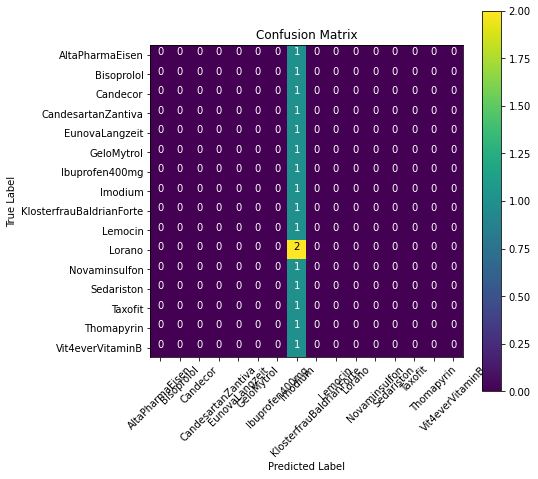

In [42]:
# Resnet50 model classification report
clf_report(true_value, resnet_pred)

Model Accuracy 0.23529411764705882
                          precision    recall  f1-score   support

         AltaPharmaEisen       0.00      0.00      0.00         1
              Bisoprolol       1.00      1.00      1.00         1
                Candecor       0.00      0.00      0.00         1
      CandesartanZantiva       0.20      1.00      0.33         1
          EunovaLangzeit       0.00      0.00      0.00         1
              GeloMytrol       0.00      0.00      0.00         1
          Ibuprofen400mg       0.00      0.00      0.00         1
                 Imodium       0.00      0.00      0.00         1
KlosterfrauBaldrianForte       0.00      0.00      0.00         1
                 Lemocin       0.00      0.00      0.00         1
                  Lorano       0.00      0.00      0.00         2
           Novaminsulfon       0.00      0.00      0.00         1
              Sedariston       0.00      0.00      0.00         1
                 Taxofit       1.00     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


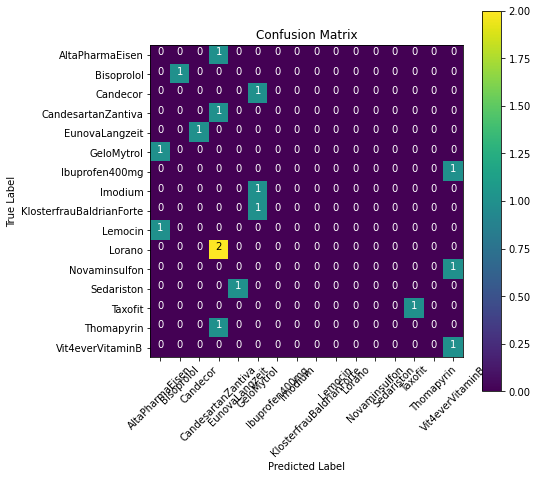

In [43]:
# Inception model classification report
clf_report(true_value, inception_pred)